### Camera Calibration Using a Cube

This notebook presents a camera calibration procedure based on a single image
of a cube. A set of corresponding 3D world points and 2D image points is used
to estimate the camera projection matrix. The camera parameters are then
extracted and visualized in a 3D scene.


**Input Image**  
The original image of the cube used for camera calibration is shown below.
The image was captured without digital zoom or cropping.


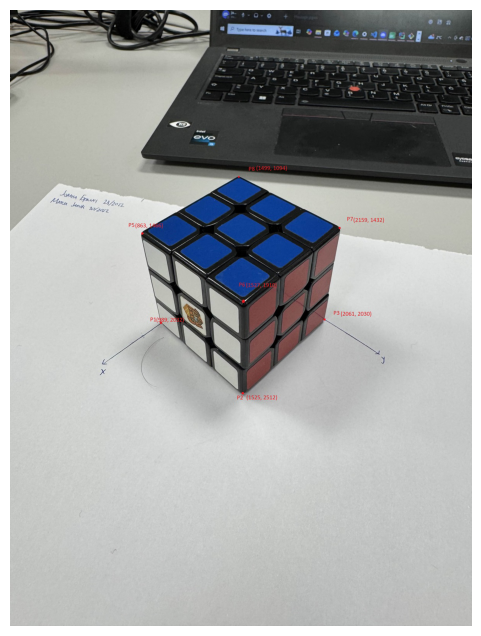

In [2]:
import matplotlib.pyplot as plt

# Load image
img = plt.imread("slika-kocka-ppgr.jpg")

# Display image
plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
plt.show()


The selected image points used for calibration are visualized on the image.


**Projection Matrix Estimation**

The camera projection matrix describes the projective mapping between 3D world
points and 2D image points. It is estimated using a linear method based on
the Direct Linear Transformation (DLT).


In [4]:
import numpy as np

def compute_projection_matrix(world_points, image_points):
    A = []

    for P, p in zip(world_points, image_points):
        X, Y, Z, W = P
        x, y, w = p

        A.append([
            X, Y, Z, W, 0, 0, 0, 0,
            -x*X, -x*Y, -x*Z, -x*W
        ])

        A.append([
            0, 0, 0, 0, X, Y, Z, W,
            -y*X, -y*Y, -y*Z, -y*W
        ])

    A = np.array(A)

    _, _, Vt = np.linalg.svd(A)

    M = Vt[-1].reshape(3, 4)

    return M


In [5]:
world_pts = np.array([
    [3, 0, 0, 1],
    [3, 3, 0, 1],
    [0, 3, 0, 1],
    [3, 0, 3, 1],
    [3, 3, 3, 1],
    [0, 3, 3, 1],
    [0, 0, 3, 1],
])

image_pts = np.array([
    [989, 2052, 1],
    [1525, 2512, 1],
    [2061, 2030, 1],
    [863, 1466, 1],
    [1527, 1910, 1],
    [2159, 1432, 1],
    [1499, 1094, 1],
])

IMG_WIDTH  = 3024
IMG_HEIGHT = 4032

def to_blue_coordinates(image_pts, width):
    blue = image_pts.copy().astype(float)
    blue[:, 0] = width - blue[:, 0]
    blue[:, 1] = blue[:, 1]
    blue[:, 2] = 1.0
    return blue


# primena
image_pts_blue = to_blue_coordinates(image_pts, IMG_WIDTH)


M = compute_projection_matrix(world_pts, image_pts_blue)
print("Projection matrix M:\n", M/M[2,3])

Projection matrix M:
 [[ 1.02921703e+02 -2.20466507e+02 -7.29423566e+01  1.51347478e+03]
 [ 5.17807658e+01  3.83168369e+01 -2.49619983e+02  1.67998595e+03]
 [-3.53781006e-02 -3.88298620e-02 -5.02254079e-02  1.00000000e+00]]


**Projection Verification**   
The estimated camera matrix is verified by projecting the 3D world points
back onto the image plane. The projected points are compared with the
original image measurements.


In [7]:
def project_point(M, P):
    p = M @ P
    return p / p[2]

print("Projection check:")
for P, p_true in zip(world_pts, image_pts_blue):
    p_est = project_point(M, P)
    print(f"Estimated: {p_est[:2]} | Measured: {p_true[:2]}")


Projection check:
Estimated: [2038.6059039  2053.24832588] | Measured: [2035. 2052.]
Estimated: [1493.28021716 2508.79687261] | Measured: [1499. 2512.]
Estimated: [ 964.42016799 2031.59627016] | Measured: [ 963. 2030.]
Estimated: [2157.47514532 1461.89947056] | Measured: [2161. 1466.]
Estimated: [1503.13302564 1917.05604554] | Measured: [1497. 1910.]
Estimated: [ 864.10841673 1427.43955791] | Measured: [ 865. 1432.]
Estimated: [1524.3276451  1096.31453618] | Measured: [1525. 1094.]


**Camera Center and Matrix Decomposition**  
The camera center is computed from the null space of the projection matrix.
The left 3×3 submatrix is then decomposed using RQ decomposition.


In [8]:
def camera_center(M):
    _, _, Vt = np.linalg.svd(M)
    C_h = Vt[-1]
    return C_h[:3] / C_h[3]

def rq_decomposition(M):
    M = np.asarray(M, dtype=float)

    M_rev = np.flipud(np.fliplr(M))
    Q_rev, R_rev = np.linalg.qr(M_rev.T)

    R = np.flipud(np.fliplr(R_rev.T))
    Q = np.flipud(np.fliplr(Q_rev.T))

    R[np.abs(R) < 1e-12] = 0.0
    Q[np.abs(Q) < 1e-12] = 0.0

    return R, Q


In [9]:
# Camera center
C = camera_center(M)
print("Camera center:\n", C)

# Left 3x3 submatrix of the projection matrix
# According to theory: M3 = K A^{-1}
M3 = M[:, :3]

# RQ decomposition
K, A_inv = rq_decomposition(M3)

# Camera-to-world rotation matrix
A = A_inv.T

# Ensure positive diagonal of K
D = np.diag(np.sign(np.diag(K)))
K = K @ D
A = D @ A

# Normalize K
K = K / K[2, 2]

print("Intrinsic matrix K:\n", K)
print("Camera orientation matrix A:\n", A)


Camera center:
 [7.19731132 7.14147375 9.31939383]
Intrinsic matrix K:
 [[3.09424670e+03 6.82831382e+00 1.62497816e+03]
 [0.00000000e+00 3.08820514e+03 1.74509523e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Camera orientation matrix A:
 [[-0.71219644  0.50578339  0.48678475]
 [-0.70083058 -0.47263325 -0.53427924]
 [-0.04015891 -0.72166541  0.69107619]]


The intrinsic matrix K contains the internal parameters of the camera,
while the camera orientation and center describe the external parameters.


**3D Scene Visualization**  
A 3D scene is created showing the cube, the world coordinate system,
and the camera coordinate system obtained from the calibration results.


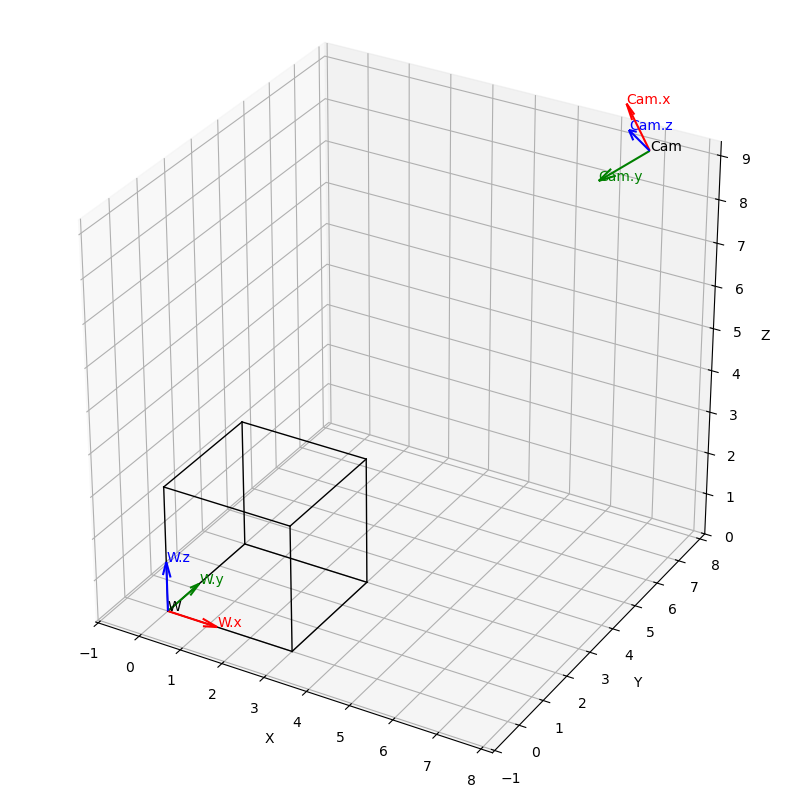

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def draw_frame(ax, origin, axes_rows, length=1.0, label=None):
    origin = np.asarray(origin, dtype=float)
    axes = np.asarray(axes_rows, dtype=float)

    colors = ['r', 'g', 'b']
    axis_names = ['x', 'y', 'z']

    for i, (color, name) in enumerate(zip(colors, axis_names)):
        v = axes[i]
        ax.quiver(
            origin[0], origin[1], origin[2],
            v[0], v[1], v[2],
            length=length, normalize=True, color=color
        )

        ax.text(
            origin[0] + length * v[0],
            origin[1] + length * v[1],
            origin[2] + length * v[2],
            f"{label}.{name}" if label else name,
            color=color
        )

    if label is not None:
        ax.text(origin[0], origin[1], origin[2], label, color='k')


def draw_cube_edges(ax, edge_length=3.0):
    L = edge_length
    vertices = np.array([
        [0, 0, 0],
        [L, 0, 0],
        [L, L, 0],
        [0, L, 0],
        [0, 0, L],
        [L, 0, L],
        [L, L, L],
        [0, L, L]
    ], dtype=float)

    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]

    for i, j in edges:
        ax.plot(
            [vertices[i, 0], vertices[j, 0]],
            [vertices[i, 1], vertices[j, 1]],
            [vertices[i, 2], vertices[j, 2]],
            'k-', linewidth=1
        )


# ----------------------------
# Scene setup
# ----------------------------
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, projection='3d')

# Draw objects
draw_cube_edges(ax, edge_length=3.0)
draw_frame(ax, origin=[0, 0, 0], axes_rows=np.eye(3), length=1.2, label="W")
draw_frame(ax, origin=C, axes_rows=A, length=1.2, label="Cam")

# Axes labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Equal aspect ratio and view limits
scene_points = np.vstack([
    np.array([[0, 0, 0], [3, 3, 3]]),
    C.reshape(1, 3)
])

mins = scene_points.min(axis=0)
maxs = scene_points.max(axis=0)

center = (mins + maxs) / 2
radius = (maxs - mins).max() / 2

ax.set_xlim(center[0] - radius, center[0] + radius)
ax.set_ylim(center[1] - radius, center[1] + radius)
ax.set_zlim(center[2] - radius, center[2] + radius)

ax.set_box_aspect([1, 1, 1])
plt.tight_layout()
plt.show()
